<a href="https://colab.research.google.com/github/josemoti1999/sysdl_project/blob/master/snn_ga_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import matplotlib.pyplot as plt
import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import copy
from torch.autograd import Variable

In [0]:
POPULATION_SIZE=100
MUTATION_POWER=0.02

In [0]:
class GeneticAlgorithm():
    def __init__(self, device, model, target, data):
        self.device=device
        self.model=model.to(self.device)
        self.target=target.to(self.device)
        self.data=data.to(self.device)

    def mutate(self, population_size=20, mutation_power=0.02):
        models_list=[]
        models_list.append(self.model)
        for _ in range(population_size):
            child=copy.deepcopy(self.model)
            for value in child.parameters():
                tensor_shape=value.shape
                noise=torch.randn(tensor_shape).to(self.device)
                value+=mutation_power*noise
            models_list.append(child)
        return models_list

    def find_best_model(self, population_size=20, mutation_power=0.02):
        models_list=self.mutate(population_size, mutation_power)
        loss_model_dict={}
        for model in models_list:
            model=model.to(self.device)
            output=model(self.data)
            loss=F.nll_loss(output, self.target)
            loss_model_dict[model]=loss
            for (model,loss) in sorted(loss_model_dict.items(), key=lambda x: x[1], reverse=False):
                model_return=model
                loss_return=loss
                break
        return model_return, loss_return

In [0]:
def train(model, device, train_set_loader, epoch, logging_interval=100):

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(train_set_loader):
            ga=GeneticAlgorithm(device,model, target, data)
            model, loss = ga.find_best_model(POPULATION_SIZE, MUTATION_POWER)
            output=model(data.to(device))
            output=output.cpu()
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, (batch_idx+1) * len(data), len(train_set_loader.dataset),
                100. * (batch_idx+1) / len(train_set_loader), loss.item(),
                100. * correct))
            break
    return model, 100.*correct

def train_many_epochs(model, tot_epochs=100):
    accuracy=0
    for epoch in range(tot_epochs):
        model, accuracy=train(model, device, test_set_loader, epoch, logging_interval=100)
        #test(model, device, test_set_loader)
    return model

def test(model, device, test_set_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss,
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")

def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

In [5]:
batch_size = 10000
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
import torch
import torch.nn as nn


class SpikingNeuronLayerRNN(nn.Module):

    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold

        self.fc = nn.Linear(n_inputs, n_hidden)

        self.init_parameters()
        self.reset_state()
        self.to(self.device)

    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)

    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):

        if self.prev_inner.dim() == 1:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])

        input_excitation = self.fc(x)
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier
        outer_excitation = (inner_excitation > self.threshold).float()
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * outer_excitation

        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output


class InputDataToSpikingPerceptronLayer(nn.Module):

    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device

        self.reset_state()
        self.to(self.device)

    def reset_state(self):
        pass

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)
        return x


class OutputDataToSpikingPerceptronLayer(nn.Module):

    def __init__(self, average_output=True):

        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.mean(dim=dim)
        else:
            self.reducer = lambda x, dim: x.sum(dim=dim)

    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)

In [0]:
class SpikingNet(nn.Module):

    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval

        self.input_conversion = InputDataToSpikingPerceptronLayer(device)

        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1, penalty_threshold=1.5
        )

        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1, penalty_threshold=1.5
        )

        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False) 

        self.to(self.device)

    def forward_through_time(self, x):

        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []

        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)

            layer1_state, layer1_output = self.layer1(xi)
            layer2_state, layer2_output = self.layer2(layer1_output)

            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)

        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]

    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))

    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))

    def plot_layer(self, layer_values, title):
        """
        This function is derived from:
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
        Which was released under the MIT License.
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

###Experinment 2
population size of 100

In [9]:
%%time

spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
spiking_model = train_many_epochs(spiking_model, tot_epochs=100)

Train Epoch: 0 [10000/10000 (100%)] Loss: 167.213806 Accuracy: 8.72%
Train Epoch: 1 [10000/10000 (100%)] Loss: 123.531166 Accuracy: 10.42%
Train Epoch: 2 [10000/10000 (100%)] Loss: 84.082184 Accuracy: 13.00%
Train Epoch: 3 [10000/10000 (100%)] Loss: 57.309555 Accuracy: 12.03%
Train Epoch: 4 [10000/10000 (100%)] Loss: 45.733524 Accuracy: 11.83%
Train Epoch: 5 [10000/10000 (100%)] Loss: 35.335663 Accuracy: 10.30%
Train Epoch: 6 [10000/10000 (100%)] Loss: 31.998838 Accuracy: 7.14%
Train Epoch: 7 [10000/10000 (100%)] Loss: 30.036615 Accuracy: 11.74%
Train Epoch: 8 [10000/10000 (100%)] Loss: 27.874580 Accuracy: 12.51%
Train Epoch: 9 [10000/10000 (100%)] Loss: 27.266537 Accuracy: 11.36%
Train Epoch: 10 [10000/10000 (100%)] Loss: 26.583019 Accuracy: 12.12%
Train Epoch: 11 [10000/10000 (100%)] Loss: 26.325216 Accuracy: 11.47%
Train Epoch: 12 [10000/10000 (100%)] Loss: 25.602690 Accuracy: 11.94%
Train Epoch: 13 [10000/10000 (100%)] Loss: 25.411959 Accuracy: 10.72%
Train Epoch: 14 [10000/10000 (

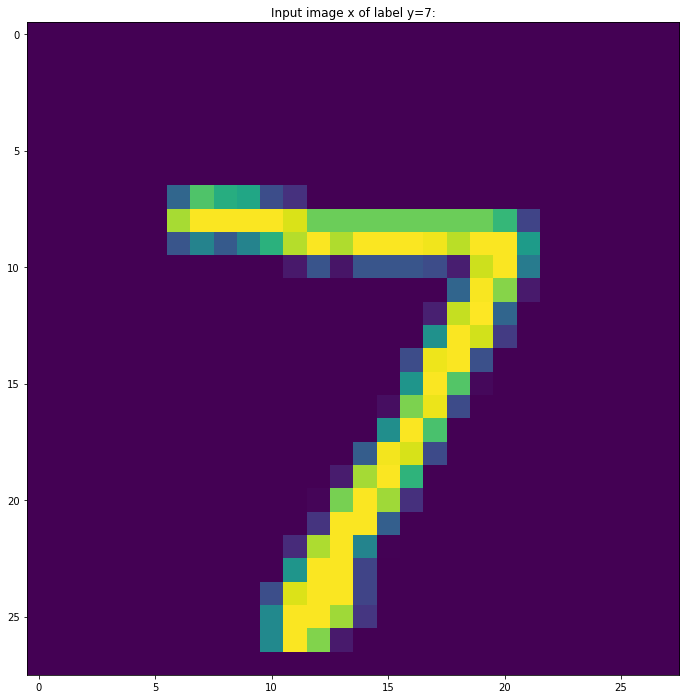

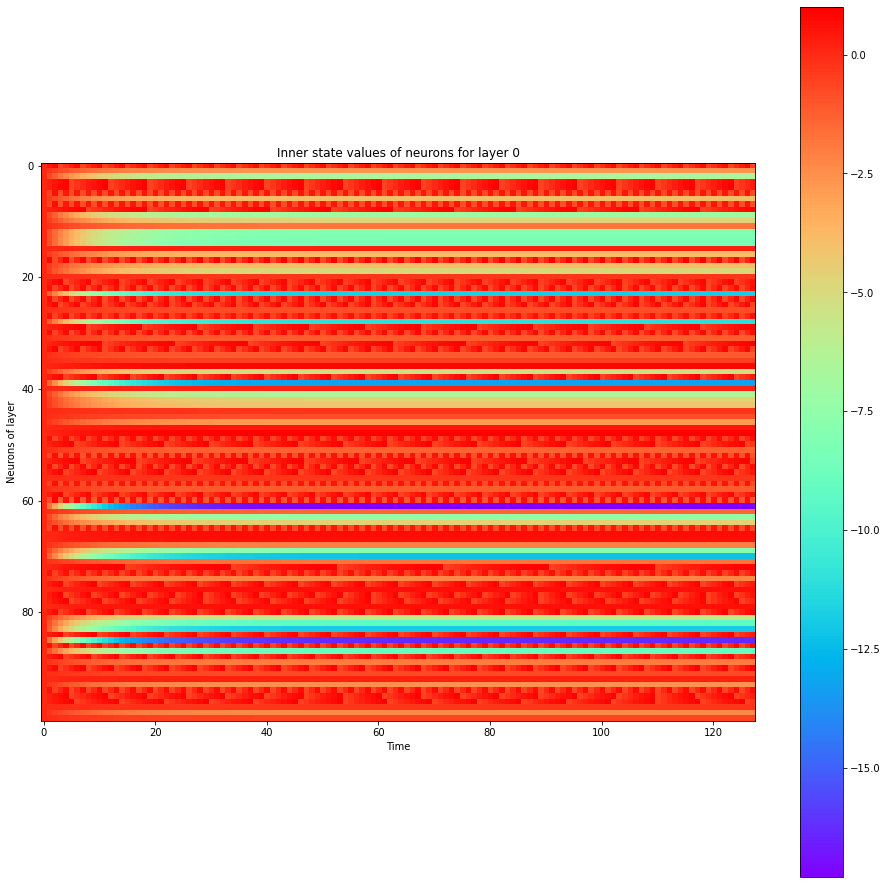

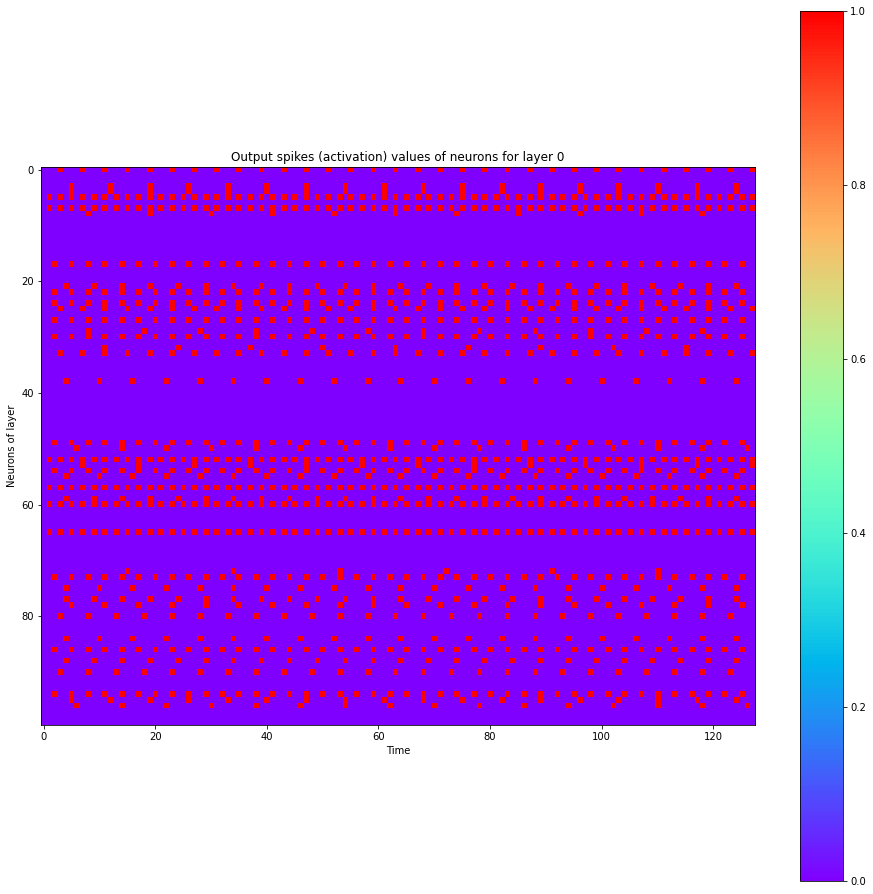

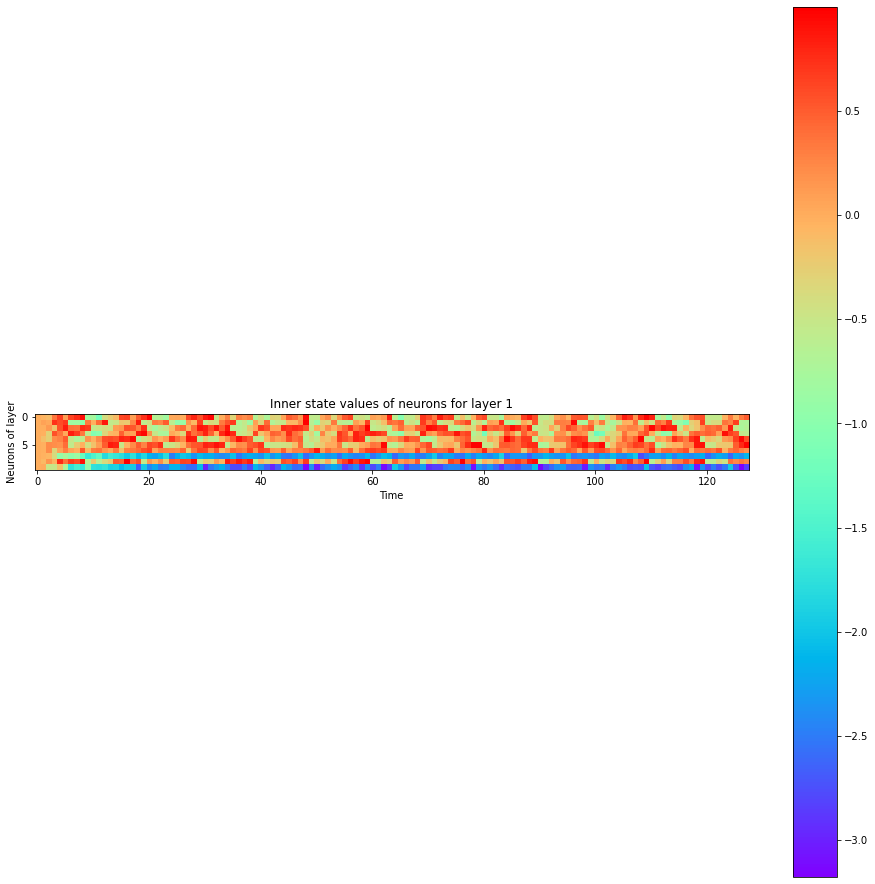

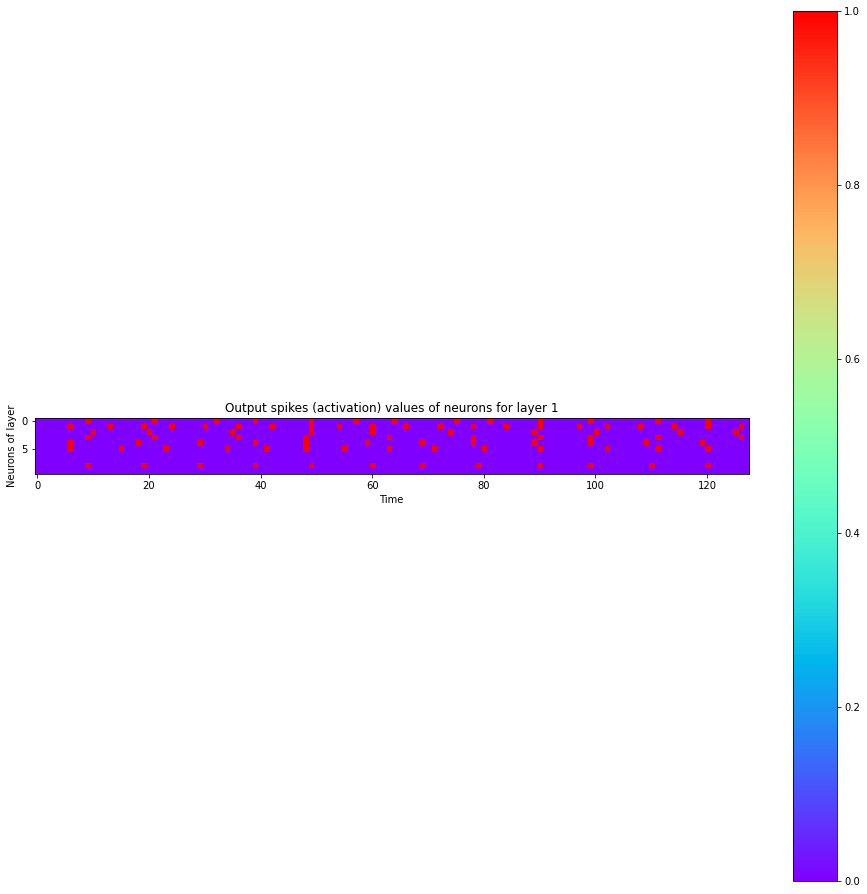

A hidden neuron that looks excited:


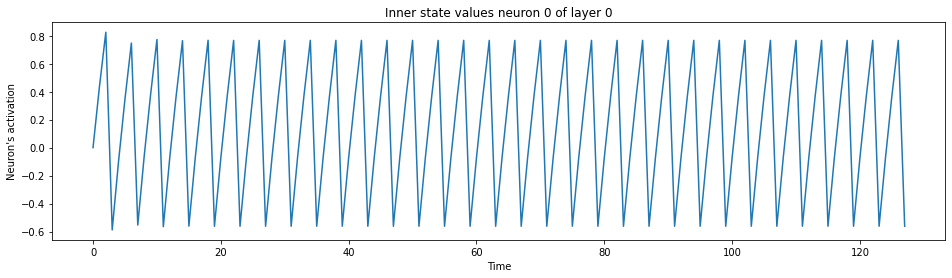

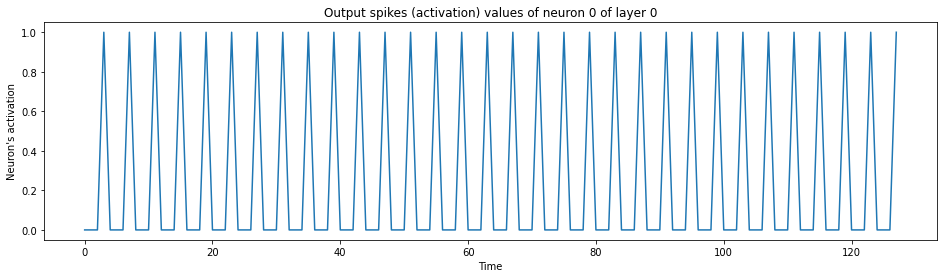

The output neuron of the label:


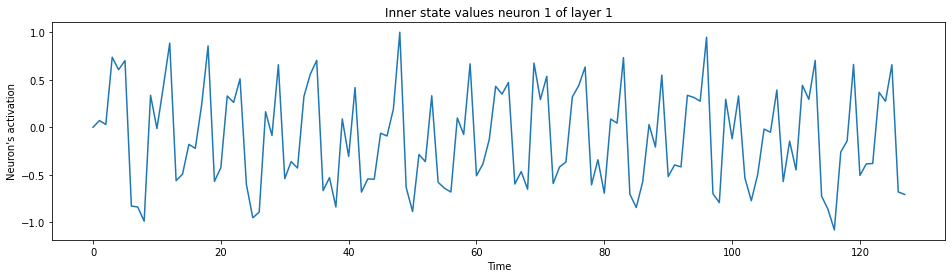

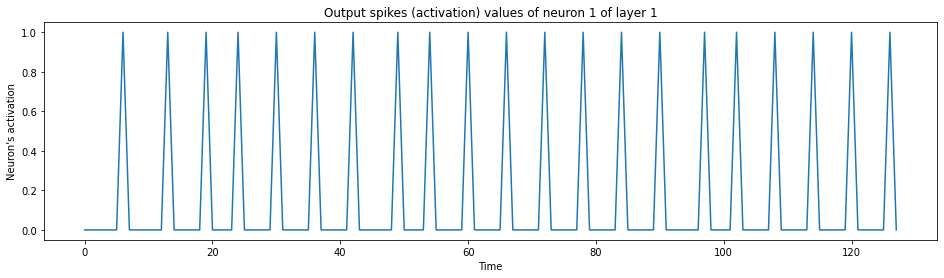

In [11]:
data, target = test_set_loader.__iter__().__next__()
spiking_model=spiking_model.to('cuda')
data=data.to('cuda')
# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=1)

###Experiment 1
Not a spiking net actually. It uses relu function rather than fixed spikes.

In [0]:
%%time

spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
spiking_model = train_many_epochs(spiking_model, tot_epochs=100)

##Non Spiking Net
Just for comparisons.


In [0]:
class NonSpikingNet(nn.Module):

    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

In [0]:
%%time

spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
model=NonSpikingNet().to(device)
train_many_epochs(model)

loss tensor(2.3040, device='cuda:0')
loss tensor(2.3870, device='cuda:0')
loss tensor(2.3707, device='cuda:0')
loss tensor(2.3843, device='cuda:0')
loss tensor(2.4041, device='cuda:0')
loss tensor(2.4419, device='cuda:0')
loss tensor(2.3812, device='cuda:0')
loss tensor(2.3543, device='cuda:0')
loss tensor(2.4668, device='cuda:0')
loss tensor(2.3935, device='cuda:0')
loss tensor(2.3796, device='cuda:0')
loss tensor(2.3750, device='cuda:0')
loss tensor(2.3554, device='cuda:0')
loss tensor(2.3769, device='cuda:0')
loss tensor(2.3612, device='cuda:0')
loss tensor(2.3072, device='cuda:0')
loss tensor(2.3493, device='cuda:0')
loss tensor(2.3806, device='cuda:0')
loss tensor(2.4829, device='cuda:0')
loss tensor(2.3320, device='cuda:0')
loss tensor(2.3909, device='cuda:0')
tensor(2.3040, device='cuda:0')
Train Epoch: 0 [0/10000 (0%)] Loss: 2.304035 Accuracy: 14.11%
loss tensor(2.3040, device='cuda:0')
loss tensor(2.3059, device='cuda:0')
loss tensor(2.3923, device='cuda:0')
loss tensor(2.3473